In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from IPython import display

from scipydirect import minimize # for DIvided RECTangles (DIRECT) method
import time

In [3]:
data = pd.read_csv("adult.csv")
print(data.shape)

(48842, 15)


In [4]:
labels = data["income"]
features = data.drop(columns=["income"])
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(34189, 14) (14653, 14) (34189,) (14653,)


In [5]:
# X_train.to_csv('./splits/X_train_adult.csv')
# X_test.to_csv('./splits/X_test_adult.csv')
# y_train.to_csv('./splits/y_train_adult.csv')
# y_test.to_csv('./splits/y_test_adult.csv')

## 1. Load and preprocess the datasets
* In the article it was wentioned, that all categorical features were encoded using one-hot scheme, whereas all numeric attributes were normalized by dividing with their mean value.

In [6]:
def encode_and_bind(original_dataframe, feature_to_encode):
    """
    To obtain dummy features from original feature `feature_to_encode`,
    add them to original dataframe `original_dataframe`,
    and drop original feature from it.
    """
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]], drop_first=True)
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

## 1.1 Adult dataset
`data_adult` - [Adult income dataset](https://www.kaggle.com/wenruliu/adult-income-dataset?select=adult.csv) comprises 48842 samples with 14 features and a label `income` with two possible values `<=50K` and `>50K`. In the article the `gender` was considered as *sensitive feature*.

Let's make the following preprocessing steps:
1. Replace values in `income`: `>50K` -> `1` and `<=50K` -> `0`. 
2. Replace values in `gender`: `Female` -> `1` and `Male` -> `0`.
3. Divide the following numerical features with their mean values: `age`, `fnlwgt`, `educational-num`, `capital-gain`, `capital-loss`, `hours-per-week`
4. Encode the following categorical features with one-hot scheme: `workclass`, `education`, `marital-status`, `occupation`, `relationship`, `race`, `native-country`

After preprocessing we will perform five 70:30 random splits to obtain training and test data, as it was described in the article. Each split corrresponds to one experiment.

In [7]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_test = pd.concat([train, test])

In [13]:
data_adult = train_test

# Replace values in 'income'
data_adult.loc[data_adult['income'] == '<=50K', 'income'] = 1
data_adult.loc[data_adult['income'] == '>50K', 'income'] = 0

# Replace values in 'gender'
data_adult.loc[data_adult['gender'] == 'Female', 'gender'] = 1
data_adult.loc[data_adult['gender'] == 'Male', 'gender'] = 0

# Normalize all numerical features by dividing with mean value
num_features_adult = ["age", "fnlwgt", "educational-num", 
                      "capital-gain", "capital-loss", "hours-per-week"]
for feature in num_features_adult:
    mean = data_adult[feature].mean()
    data_adult[feature] = data_adult[feature] / mean

# Make dummy features for all categorical features
cat_features_adult = ["workclass", "education", "marital-status", "race",
                      "occupation", "relationship", "native-country"]
for feature in cat_features_adult:
    data_adult = encode_and_bind(data_adult, feature)

In [14]:
data_adult.shape

(48842, 101)

# 2. Adaptive Sensitive Reweightening (ASR) + CULEP model

## 2.1 Adaptive Sensitive Reweightening (`ReweightedClassifier`) 

In [15]:
class ReweightedClassifier:
    def __init__(self, baze_clf, alpha, beta, params = {}):
        """
        Input: 
        baze_clf   - object from sklearn with methods .fit(sample_weight=), .predict(), .predict_proba()
        alpha      - list of alphas for sensitive and non-sensitive objects [alpha, alpha']
        beta       - list of betss for sensitive and non-sensitive objects [beta, beta']
        params     - **kwargs compatible with baze_clf
        
        """
        self.baze_clf = baze_clf 
        self.model = None
        self.alpha = np.array(alpha)
        self.alphas = None
        self.beta = np.array(beta)
        self.betas = None
        self.weights = None
        self.prev_weights = None
        self.params = params
    
    def reweight_dataset(self, length, error, minority_idx):
        """
        This function recalculates values of weights and saves their previous values
        """
        if self.alphas is None or self.betas is None:
            # If alpha_0, alpha_1 or beta_0, beta_1 are not defined,
            # then define alpha_0 and beta_0 to every object from non-sensitive class,
            # and alpha_1 and beta_1 to every object from sensitive class (minority).
            self.alphas = np.ones(length) * self.alpha[0]
            self.betas = np.ones(length) * self.beta[0]
            self.alphas[minority_idx] = self.alpha[1]
            self.betas[minority_idx] = self.beta[1]
        
        # w_i_prev <- w_i for all i in dataset
        self.prev_weights = self.weights.copy()
        
        # w_i = alpha_i * L_{beta_i} (P'(y_pred_i =! y_true_i)) 
        #       + (1 - alpha_i) * L_{beta_i} (-P'(y_pred_i =! y_true_i)),
        # where 
        # L_{beta_i} (x) = exp(beta_i * x)
        self.weights = self.alphas * np.exp(self.betas * error) \
                       + (1 - self.alphas) * np.exp(- self.betas * error)
    
    
    def pRule(self, prediction, minority_idx):
        """
        This function calculates 
                    | P(y_pred_i = 1 | i in S)       P(y_pred_i = 1 | i not in S) |
        pRule = min { ---------------------------- , ---------------------------- }
                    | P(y_pred_i = 1 | i not in S)   P(y_pred_i = 1 | i in S)     |
        
        S - the group of sensitive objects
        ---------
        Input:
        prediction - labels ({0,1}) of a sample for which pRule is calculated
        minority_idx - indexes of objects from a sensitive group
        """
        # majority indexes = set of all indexes / set of minority indexes,
        # where set of all indexes = all numbers from 0 to size of sample (=len(prediction))
        majority_idx = set(np.linspace(0, len(prediction) - 1, len(prediction), dtype = int)).difference(minority_idx)
        
        # minority = P(y_pred_i = 1 | i in minority)
        # majority = P(y_pred_i = 1 | i in majority)
        minority = prediction[minority_idx].mean()
        majority = prediction[list(majority_idx)].mean()
        
        minority = np.clip(minority, 1e-10, 1 - 1e-10)
        majority = np.clip(majority, 1e-10, 1 - 1e-10)
        
        return min(minority/majority, majority/minority)

        
    
    def fit(self, X_train, y_train, X_test, y_test, minority_idx, verbose=True, max_iter=30):
        # Initialize equal weights w_i = 1
        self.weights = np.ones(len(y_train))
        self.prev_weights = np.zeros(len(y_train))
        
        # Lists for saving metrics
        accuracys = []
        pRules = []
        differences = []
        accuracy_plus_prule = []
        
        # Adaptive Sensitive Reweighting
        iteration = 0
        
        while ((self.prev_weights - self.weights) ** 2).mean() > 10**(-6) and iteration < max_iter:
            
            iteration += 1
            # Train classifier on X_train with weights (w_i / sum(w_i))
            self.model = self.baze_clf(**self.params)
            self.model.fit(X_train, y_train,
                           sample_weight = self.weights / (self.weights.sum()))
            
            # Use classifier to obtain P`(y_pred_i =! y_pred) (here it is called 'error')
            prediction_proba = self.model.predict_proba(X_train)[:, 1]
            error = prediction_proba - y_train
    
            # Update weights
            self.reweight_dataset(len(y_train), error, minority_idx)
            
            # Get metrics on X_train
            prediction = self.model.predict(X_train)
            accuracys.append(accuracy_score(prediction, y_train))
            pRules.append(self.pRule(prediction, minority_idx))
            accuracy_plus_prule.append(accuracys[-1] + pRules[-1])
            differences.append(((self.prev_weights - self.weights)**2).mean()**0.5)
            
            # Visualize metrics if it's needed
            if verbose:
                display.clear_output(True)
                fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 7))

                metrics = [accuracys, pRules, accuracy_plus_prule, differences]
                metrics_names = ["Accuracy score", "pRule", "Accuracy + pRule", "Mean of weight edits"]
                for name, metric, ax in zip(metrics_names, metrics, axes.flat):
                    ax.plot(metric, label='train')
                    ax.set_title(f'{name}, iteration {iteration}')
                    ax.legend()
                    if name == "Mean of weight edits":
                        ax.set_yscale('log')
                plt.show()
                
        return accuracys, pRules, accuracy_plus_prule, differences
        
        
    def predict(self, X):
        return self.model.predict(X)
    
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def get_metrics_test(self, X_test, y_test, minority_idx_test):
        """
        Obtain pRule and accuracy for trained model
        """
        # Obtain predictions on X_test to calculate metrics
        prediction_test = self.model.predict(X_test)

        # Get metrics on test
        accuracy_test = accuracy_score(prediction_test, y_test)
        pRule_test = self.pRule(prediction_test, minority_idx_test)

        return accuracy_test, pRule_test 

## 2.2. Optimizing CULEP parameter (`train_model`)

In the article CULEP parameters are $\alpha, \alpha', \beta, \beta'$. They searched for the optimal hyperparameters in the space $\left( \alpha, \alpha', \beta, \beta' \right) \in \left[ 0, 1 \right] ^2 \times \left[ 0, 3 \right] ^2$ and used for it DIvided RECTangles (DIRECT) method. 

Each combination of parameters is evaluated with a full run of Adaptive Sensitive Reweightening algorithm on the training set. After optimization of the objective function (in case of Adult dataset it is `accuracy + pRule`), we get optimal hyperparameters $\alpha, \alpha', \beta, \beta'$. Then trained model (on the training set) with these hyperparameters make predictions on test set and the obtained metrics (accuracy and pRule) are reported.

The optimization of objective function is time-consuming. For one split on train and test sets this process can take up to **2 hours** for Adult dataset. The whole process is repeated for 5 different random splits on train and test sets. 

To be able to keep track of the process each split will be started in its own cell (instead of a loop). Each split will correspont to one experiment.


In [16]:
def prep_train_model(X_train, y_train, X_test, y_test, minority_idx):
    
    def train_model(a):
        """
        Function of 4 variables (a[0], a[1], a[2], a[3]) that will be minimized by DIRECT method.
        a[0], a[1] = alpha, alpha'
        a[2], a[3] = beta, beta'
        """
        model = ReweightedClassifier(LogisticRegression, [a[0], a[1]], [a[2], a[3]], params = {"max_iter": 4000, 'solver':'liblinear'})
        _, _, accuracy_plus_prule, _ = model.fit(X_train, y_train, X_test, y_test, minority_idx)

        # We'll maximize [acc + pRule] which we get at the last iteration of Adaptive Sensitive Reweighting
        return - accuracy_plus_prule[-1]
    
    return train_model # return function for optimization

# 3. Experiments

In order to make all experiments independent from each other, all necessary variables will have name endings either `_1`, `_2`, `_3`, `_4` or `_5`.

## 3.1. Experiment 1

1) Obtain a split for the experiment.

In [19]:
train_after_join = data_adult.values[:X_train.shape[0]] # X_train + y_train
test_after_join = data_adult.values[X_train.shape[0]:] # X_test + y_test

pd_train_after_join = pd.DataFrame(train_after_join, columns=data_adult.columns) # X_train + y_train
pd_test_after_join = pd.DataFrame(test_after_join, columns=data_adult.columns) # X_test + y_test

y_train_1 = pd_train_after_join["income"]
X_train_1 = pd_train_after_join.drop(columns=["income"])

y_test_1 = pd_test_after_join["income"]
X_test_1 = pd_test_after_join.drop(columns=["income"])

# X_train_1.to_csv('./splits/X_train_preprocessed_adult.csv')
# X_test_1.to_csv('./splits/X_test_preprocessed_adult.csv')
# y_train_1.to_csv('./splits/y_train_preprocessed_adult.csv')
# y_test_1.to_csv('./splits/y_test_preprocessed_adult.csv')


y_train_1 = y_train_1.astype(int).values
y_test_1 = y_test_1.astype(int).values

# Obtain indexes of sensitive class
minority_idx_1 = X_train_1.reset_index(drop=True).index.values[X_train_1["gender"] == 1]
minority_idx_test_1 = X_test_1.reset_index(drop=True).index.values[X_test_1["gender"] == 1]

2) Perform ASR+CULEP.

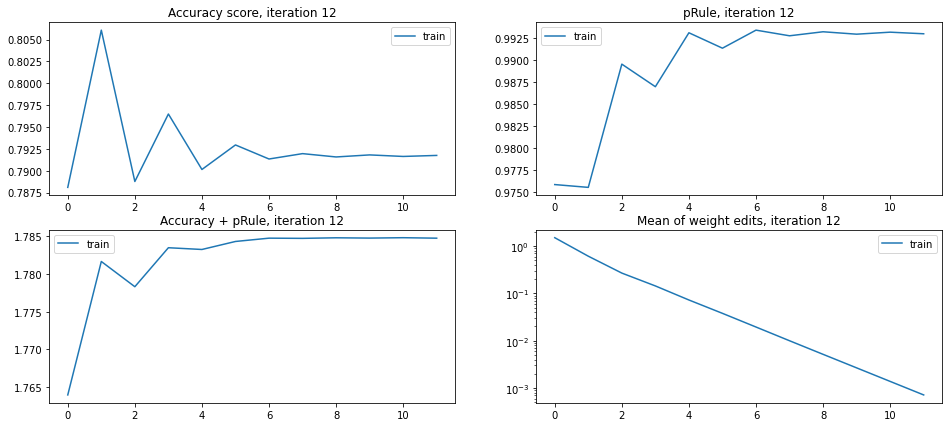

Elapsed time: 7395.5169360637665 s
Elapsed time: 123.0 min 15.51693606376648 s
       x: array([0.11728395, 0.98148148, 1.4382716 , 2.99382716])
     fun: -1.7849677888177793
  status: 1
 success: True
 message: 'Number of function evaluations done is larger then maxf'


In [24]:
objective_1 = prep_train_model(X_train_1, y_train_1, X_test_1, y_test_1, minority_idx_1)

start = time.time()
my_res_1 = minimize(objective_1, bounds=[[0.0, 1.0], [0.0, 1.0], [0.0, 3.0], [0.0, 3.0]], maxT=160, maxf=320)
stop = time.time()

print(f"Elapsed time: {stop - start} s")
print(f"Elapsed time: {(stop - start) // 60} min {(stop - start) % 60} s")
print(my_res_1)

3) Get necessary metrics on test set (for Adult dataset the metrics are accuracy and pRule).

In [33]:
# Create model with obtained hyperparameters alpha, alpha', beta, beta'
a_1 = [0.11728395, 0.98148148, 1.4382716,  2.99382716] #my_res_1.x
model_1 = ReweightedClassifier(LogisticRegression, [a_1[0], a_1[1]], [a_1[2], a_1[3]], params = {"max_iter": 4000, 'solver':'liblinear'})

# Train model on X_train 
model_1.fit(X_train_1, y_train_1, X_test_1, y_test_1, minority_idx_1, verbose=False)

# Calculate metrics (pRule, accuracy) on X_test
accuracy_test_1, pRule_test_1 = model_1.get_metrics_test(X_test_1, y_test_1, minority_idx_test_1)

print('ASR+CULEP for X_test')
print(f"prule = {pRule_test_1:.6}, accuracy = {accuracy_test_1:.6}")
print(f"prule + accuracy = {(pRule_test_1 + accuracy_test_1):.6}")

ASR+CULEP for X_test
prule = 0.981073, accuracy = 0.800587
prule + accuracy = 1.78166


In [36]:
y_pred_test = model_1.predict(X_test_1)
accuracy_score(y_pred_test, y_test_1)

0.8005869105302669

In [37]:
pd.DataFrame(y_pred_test).to_csv('./predictions/y_pred_test_adult.csv')

4) For the same split train simple Logistic Regression (without ASR+CULEP) on the train set. Then obtain necessary metrics on the test set.

In [32]:
# Fit LogisticRegression on X_train
model_simple = LogisticRegression(max_iter=4000, solver='liblinear')
model_simple.fit(X_train_1, y_train_1)

# Get predictions for X_test
prediction = model_simple.predict(X_test_1)

# Obtain indexes for sensitive and non-sensitive groups
majority_idx_test_1 = set(np.linspace(0, len(prediction) - 1, len(prediction), dtype = int)).difference(minority_idx_test_1)       
minority = prediction[minority_idx_test_1].mean()
majority = prediction[list(majority_idx_test_1)].mean()

# Calculate metrics on X_test
prule_simple = min(minority/majority, majority/minority)
accuracy_simple = accuracy_score(prediction, y_test_1)

print('Without ASR+CULEP for X_test')
print(f"prule = {prule_simple:.6}, accuracy = {accuracy_simple:.6}")
print(f"prule + accuracy = {(prule_simple + accuracy_simple):.6}")

Without ASR+CULEP for X_test
prule = 0.811292, accuracy = 0.854979
prule + accuracy = 1.66627
